In [1]:
import pandas as pd
import quandl
import math, datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,  svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from matplotlib import style
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import ExtraTreesRegressor

style.use("ggplot")

In [61]:
quandl.ApiConfig.api_key = "LS8KfrVvkFyc72zcv5sN"

df = quandl.get("WIKI/GOOGL")

In [62]:
df

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,1092.57,1108.70,1087.21,1094.000,1990515.0,0.0,1.0,1092.570000,1108.700000,1087.210000,1094.000000,1990515.0
2018-03-22,1080.01,1083.92,1049.64,1053.150,3418154.0,0.0,1.0,1080.010000,1083.920000,1049.640000,1053.150000,3418154.0
2018-03-23,1051.37,1066.78,1024.87,1026.550,2413517.0,0.0,1.0,1051.370000,1066.780000,1024.870000,1026.550000,2413517.0


In [63]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [64]:
df = df[['Adj. Close', 'Adj. Open', 'PCT_change', 'HL_PCT', 'Adj. Volume']]

In [65]:
df

,Adj. Close,Adj. Open,PCT_change,HL_PCT,Adj. Volume
Date,,,,,
2004-08-19,50.322842,50.159839,0.324968,3.712563,44659000.0
2004-08-20,54.322689,50.661387,7.227007,0.710922,22834300.0
2004-08-23,54.869377,55.551482,-1.227880,3.729433,18256100.0
2004-08-24,52.597363,55.792225,-5.726357,6.417469,15247300.0
2004-08-25,53.164113,52.542193,1.183658,1.886792,9188600.0
...,...,...,...,...,...
2018-03-21,1094.000000,1092.570000,0.130884,1.343693,1990515.0
2018-03-22,1053.150000,1080.010000,-2.487014,2.921711,3418154.0
2018-03-23,1026.550000,1051.370000,-2.360729,3.918952,2413517.0


In [66]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

In [67]:
forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out) 

In [68]:
X = np.array(df[['Adj. Close', 'Adj. Open', 'PCT_change', 'HL_PCT', 'Adj. Volume']])
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [70]:
clf = LinearRegression()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9777594336167701


In [71]:
with open("linearregression.pickle", "wb") as f:
    pickle.dump(clf, f)

pickle_in = open("linearregression.pickle", "rb")
clf = pickle.load(pickle_in)

In [72]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[1074.57821182 1088.45752673 1102.39348971 1099.02043993 1093.16989529
 1090.07430094 1088.10011926 1085.37818064 1079.55862475 1075.12630191
 1072.32280205 1087.69058836 1106.40119394 1114.19880476 1127.85277557
 1132.42373097 1132.71306972 1128.75359888 1131.19242311 1145.71577505
 1149.45540093 1158.29263942 1155.75399196 1162.10921659 1179.35211424
 1194.54200301 1191.66214835 1201.49892447 1207.50173144 1205.13467992
 1195.75947622 1201.95323766 1199.14110742 1137.20696041 1086.27812872] 0.9777594336167701 35


In [73]:
df["Forecast"] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

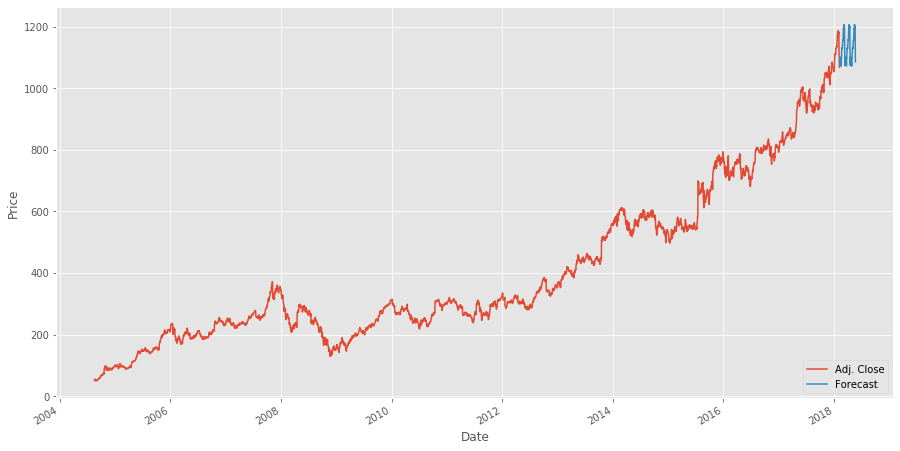

In [76]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

plt.figure(figsize=(15,8))
df["Adj. Close"].plot()
df["Forecast"].plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [139]:
# scores = {
#     1: [],
#     2: [],
#     3: [],
#     4: [],
#     5: [],
#     6: []
# }

# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.tree import DecisionTreeRegressor

# models = [LinearRegression(), svm.LinearSVR(), svm.SVR(), DecisionTreeRegressor(), ExtraTreesRegressor(), KNeighborsRegressor()]
# kf = KFold(n_splits=5, shuffle=True, random_state=2)
# def trainer(model):
#     for num, model in enumerate(models, start=1):
#         for train_index, test_index in kf.split(X_train):
#             X_trains, X_tests = X_train[train_index], X_train[test_index]
#             y_trains, y_tests = y_train[train_index], y_train[test_index]
#             md = model
#             md.fit(X_trains, y_trains)
#             scores.get(num).append(md.score(X_tests, y_tests))

In [140]:
# trainer(models)
# print(scores)

In [141]:
# names = ["Linear Regression", "Linear SVR", "SVR", "Decision Tree Regressor", "ExtraTreeRegressor", "KNN"]
# for n, v in zip(names, scores.values()):
#     mean = np.mean(v)
#     print("{}: {}".format(n, mean))

In [142]:
# ex = ExtraTreesRegressor()
# ex.fit(X_train, y_train)
# ex.score(X_test, y_test)

In [143]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "n_estimators": [20, 30, 40, 60, 80, 100, 120, 140, 180, 200],
#     "bootstrap": [True, False]
# }

# ex = ExtraTreesRegressor()
# gs = GridSearchCV(ex, param_grid, cv=5)
# gs.fit(X_train, y_train)

In [145]:
# print("best params:", gs.best_params_)

In [146]:
# final_model = ExtraTreesRegressor(bootstrap=True, n_estimators=180)
# final_model.fit(X_train, y_train)

In [147]:
# final_model.score(X_test, y_test)

In [5]:
data = {
    "a": [1,2,3,4,5,6,7,8,9,10],
    "b": [2,4,6,8,10,12,14,16,18,20]
}

dfs = pd.DataFrame(data)

In [6]:
dfs

,a,b
0,1,2
1,2,4
2,3,6
3,4,8
4,5,10
5,6,12
6,7,14
7,8,16
8,9,18
9,10,20


In [7]:
dfs["b"].shift(3)

0     NaN
1     NaN
2     NaN
3     2.0
4     4.0
5     6.0
6     8.0
7    10.0
8    12.0
9    14.0
Name: b, dtype: float64

In [8]:
dfs["b"].shift(-3)

0     8.0
1    10.0
2    12.0
3    14.0
4    16.0
5    18.0
6    20.0
7     NaN
8     NaN
9     NaN
Name: b, dtype: float64

In [9]:
import tensorflow

In [10]:
full_value = np.full((2,3), 99)

In [11]:
full_value

array([[99, 99, 99],
       [99, 99, 99]])

In [12]:
df_dict2 = {'Name': ['James', 'Yemen', 'Caro', np.nan],
           'Profession': ['Researcher', 'Artist', 'Doctor', 'Writer'],
           'Experience': [12, np.nan, 10, 8],
           'Height': [np.nan, 175, 180, 150]}

In [15]:
df2 = pd.DataFrame(df_dict2)

In [16]:
df2

,Name,Profession,Experience,Height
0,James,Researcher,12.0,NaN
1,Yemen,Artist,NaN,175.0
2,Caro,Doctor,10.0,180.0
3,NaN,Writer,8.0,150.0


In [17]:
df2.dropna(axis=1, inplace=True)

In [21]:
df2.isnull().sum()

Profession    0
dtype: int64

In [23]:
ai = pd.read_html("https://www.javatpoint.com/difference-between-artificial-intelligence-and-machine-learning#:~:text=On%20a%20broad%20level%2C%20we,data%20without%20being%20programmed%20explicitly.")

In [33]:
print(ai[2].)

Artificial Intelligence  \
0   Artificial intelligence is a technology which ...   
1   The goal of AI is to make a smart computer sys...   
2   In AI, we make intelligent systems to perform ...   
3   Machine learning and deep learning are the two...   
4                  AI has a very wide range of scope.   
5   AI is working to create an intelligent system ...   
6   AI system is concerned about maximizing the ch...   
7   The main applications of AI are Siri, customer...   
8   On the basis of capabilities, AI can be divide...   
9   It includes learning, reasoning, and self-corr...   
10  AI completely deals with Structured, semi-stru...   

                                     Machine learning  
0   Machine learning is a subset of AI which allow...  
1   The goal of ML is to allow machines to learn f...  
2   In ML, we teach machines with data to perform ...  
3   Deep learning is a main subset of machine lear...  
4               Machine learning has a limited scope.  
5   Machi